# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 16 - 4to bimestre 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta **las 20hs del Lunes 21 de octubre**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (permitir acceso a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com) y **se realizará en el siguiente link de google form: [link](https://docs.google.com/forms/d/e/1FAIpQLSc8dLsaaKQxAbtTv5RejE6TxifO_BugdeEU_IdhKl39qMvoMg/viewform?usp=sf_link)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN CORREO AVISANDO DE LA ENTREGA!

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP Co(numero de cohorte).ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.


**Condiciones de aprobación**
- Se aprueba con más del 60% del examen bien resuelto de cada parte del TP (Parte 1 y Parte 2).
- La escala de notas empleada por la UBA es aprobado para nota igual o superior a 4.

## Paquetes y funciones auxiliares a utilizar

In [2]:
# ---------------- Paquetes a utilizar ----------------

# Manipulación de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de variables / métricas
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics


# Redes neuronales
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



In [3]:
# Función para graficar variables categóricas con cierta estandarización y varias opciones

def plot_variable_cat(df, column_name, ax, color_palette='Reds_r',
                      grid_interval=5000, orientation='vertical', size_font=7):

    # Frecuencias de las categorías
    value_counts = df[column_name].value_counts()

    # Se determinan si las categorías son numéricas o alfanuméricas y se ordenan
    try:
        sorted_categories = sorted(value_counts.index, key=lambda x: int(x))
    except ValueError:
        sorted_categories = sorted(value_counts.index)

    # Se ordenan las frecuencias por las categorías ordenadas
    value_counts = value_counts.reindex(sorted_categories)

    # Cálculo de los porcentajes
    percentages = (value_counts / value_counts.sum()) * 100

    # Paleta de colores
    cmap = plt.colormaps[color_palette]
    colors = cmap(np.linspace(0.4, 1, len(value_counts)))

    # Orientación del gráfico
    if orientation == 'horizontal':
        # Gráfico de barras horizontales
        bars = ax.barh(value_counts.index, value_counts, color=colors)
        ax.invert_yaxis()  # Invertir el eje Y para que la barra más larga esté arriba
        ax.set_xlabel('Frecuencia')
        ax.set_ylabel(column_name)
        ax.set_xticks(np.arange(0, max(value_counts) + grid_interval, grid_interval))
        ax.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)

        # Se añaden los porcentajes a las barras
        for bar, percentage in zip(bars, percentages):
            ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                    f'{percentage:.2f}%', va='center', ha='left')

    else:
        # Gráfico de barras verticales
        bars = ax.bar(value_counts.index, value_counts, color=colors)
        ax.set_ylabel('Frecuencia')
        ax.set_xlabel(column_name)
        ax.set_yticks(np.arange(0, max(value_counts) + grid_interval, grid_interval))
        ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)

        # Se configuran las etiquetas del eje X ordenadas
        ax.set_xticks(np.arange(len(value_counts)))


        # Añadir los porcentajes a las barras
        for bar, percentage in zip(bars, percentages):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{percentage:.2f}%', va='bottom', ha='center', fontsize=size_font)

    ax.set_title(f'Clases variable {column_name}')


In [4]:
# Función para ver valores faltantes de atributos que componen el dataset
def miss_data(df_train, col):

    # Total de filas del df original
    total_filas = len(df_train)

    # Lista para ir agregando los resultados
    resultados = []

    for var in col:
        valores_faltantes = df_train[var].isna().sum()
        proporcion_faltantes = valores_faltantes/total_filas
        resultados.append({
            'Columna': var,
            'Total_Filas': total_filas,
            'Valores_Faltantes': valores_faltantes,
            'Prop_faltantes': proporcion_faltantes
        })

    resultado_df_train = pd.DataFrame(resultados)

    return resultado_df_train

# Parte 1
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
- a) Analizar y preparar el dataset.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`** . Graficar las evoluciones de la funcion de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.
- c)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.
- d) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.

Para el punto e) vamos a considerar un problema de regresion, donde la salida es cuanto gasto el cliente:
- e)	Entrenar un de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.
- f) Para el mejor modelo obtenido en el apartado e) elegir al menos 2 hiperparámetros para tunear. Explicar el metodo utilizado y los resultados obtenidos.



## Resolución Parte 1

### Parte (a)

Analizar y preparar el dataset.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).

In [5]:
# Carga de datos

id = '1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd'
url = f'https://drive.google.com/uc?id={id}'
datos = pd.DataFrame(pd.read_csv(url))

In [6]:
# Vista rápida de datos para controlar que hayan cargado bien
datos.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
# Información general de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


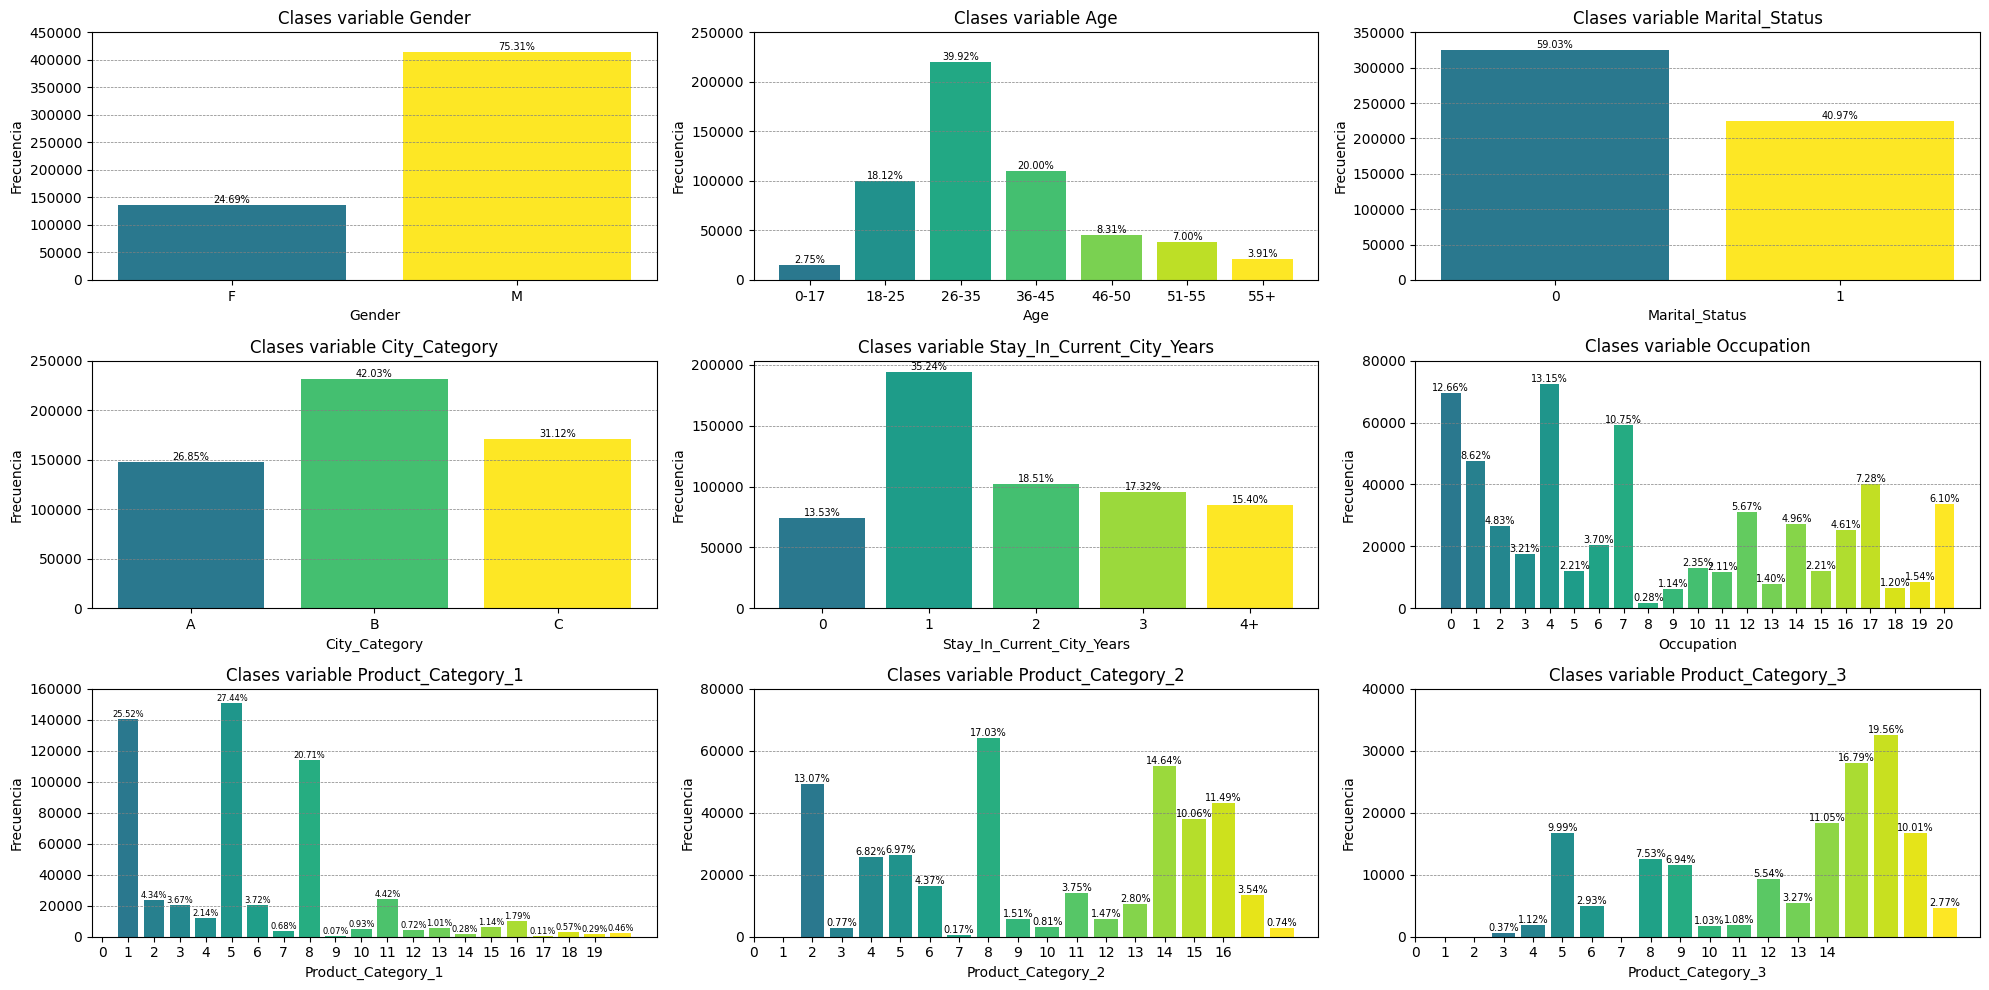

In [8]:
# Plots de variables categóricas
fig, axs = plt.subplots(3, 3, figsize=(20, 10))

plot_variable_cat(datos, 'Gender',                      ax = axs[0,0], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Age',                         ax = axs[0,1], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Marital_Status',              ax = axs[0,2], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'City_Category',               ax = axs[1,0], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Stay_In_Current_City_Years',  ax = axs[1,1], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Occupation',                  ax = axs[1,2], color_palette='viridis', grid_interval=20000)
plot_variable_cat(datos, 'Product_Category_1',          ax = axs[2,0], color_palette='viridis', grid_interval=20000, size_font = 6)
plot_variable_cat(datos, 'Product_Category_2',          ax = axs[2,1], color_palette='viridis', grid_interval=20000)
plot_variable_cat(datos, 'Product_Category_3',          ax = axs[2,2], color_palette='viridis', grid_interval=10000)

plt.tight_layout()
plt.show()

En el gráfico se pueden observar varios puntos:
- Los hombres fueron significativamente más activos en las compras durante el período de análisis.
- El grupo de edad más grande es el de 26-35 años (39.92%), seguido de los de 36-45 años (20.00%) y 18-25 años (18.12%). Estos tres grupos combinados dominan las compras, lo que indica que las personas jóvenes y de mediana edad fueron los compradores principales.
- Un 59.03% de los compradores están casados, mientras que un 40.97% no lo está. Esto podría sugerir que los clientes casados tienen una mayor tendencia a participar en eventos de compras como estos.
- Las ocupaciones de los clientes son variadas, pero la mayor parte de los compradores se concentran en unas pocas "ocupaciones", con los códigos 0, 4 y 7 como los más comunes., lo que puede señalar que ciertas profesiones tienen más propensión a participar en eventos de compras
- Las categorías de productos de primera categoría más compradas son las de productos con el código 5 (27.44%), 1 (25.52%) y 8 (20.71%). Estas categorías dominan las compras, por lo que pueden ser productos populares.
- En cuanto a los productos de categoría 2 y 3 son más diversificados, incluso no comprados en algunos casos (presentan valores faltantes que se verán más adelante).


#### Procesamiento de datos

Hay que armar las categorías específicas según el gasto del cliente ($GC$), para poder entrenar / validar el modelo que prediga esto.
- **Cat. 0**: $GC < 5000$
- **Cat. 1**: $5000 \leq GC < 10000$
- **Cat. 2**: $10000 \leq GC < 15000$
- **Cat. 3**: $15000 \leq GC$

In [9]:
# Se arman las categorías especificadas, ademas de calcular las proporciones de cada clase
# - Se ven que las clases "objetivo" están desbalanceadas

datos['GC_Category'] = pd.cut(datos['Purchase'], bins=[0, 5000, 10000, 15000, np.inf], labels=[0, 1, 2, 3])
GC_count = pd.DataFrame(datos['GC_Category'].value_counts().sort_index())
GC_count['prop'] = (GC_count / GC_count.sum())
GC_count


,count,prop
GC_Category,,
0,94923,0.172566
1,265695,0.483022
2,78927,0.143486
3,110523,0.200926


La categoría 1 contiene casi la mitad de los registros (48.30%), mientras que las demás categorías están mucho menos representadas, claramente se observa un desbalance.

Se observan datos faltantes, específicamente en 2 variables: `Product_Category_2` y `Product_Category_3`. Como se ve abajo, son una proporción relativamente grande con respecto a los datos, por lo que hay que darle algún tratamiento. Se le asigna una clase residual por el momento (`99`).

In [10]:
miss_data(datos, datos.columns)[miss_data(datos, datos.columns)['Prop_faltantes'] > 0]


,Columna,Total_Filas,Valores_Faltantes,Prop_faltantes
9,Product_Category_2,550068,173638,0.315666
10,Product_Category_3,550068,383247,0.696727


In [11]:
# Se asigna '99' ("sin dato") a valores faltantes
datos['Product_Category_2'] = datos['Product_Category_2'].fillna(99)
datos['Product_Category_3'] = datos['Product_Category_3'].fillna(99)

Si bien las variables `Occupation`, `Marital Status`, `Product_Category_1`, `Product_Category_2` y `Product_Category_3`, están como tipo `int64` y `float64`, lo que terminan representando son categorías, así que se definen de esta manera para poder convertir en variables binarias luego mediante One-Hot-Encoding.

In [12]:
# Preprocesamiento de float64 a int64
datos['Product_Category_2'] = datos['Product_Category_2'].astype('int64')
datos['Product_Category_3'] = datos['Product_Category_3'].astype('int64')

# Lista de columnas a convertir en categóricas
cat_variables = [
    'Occupation',
    'Marital_Status',
    'Product_Category_1',
    'Product_Category_2',
    'Product_Category_3'
]

# Convertimos las columnas a tipo 'category'
datos[cat_variables] = datos[cat_variables].astype('category')

In [13]:
# Nos quedamos solo con las variables relevantes para el modelo
# - En este caso no se utilizan embeddings, así que se descarta User_ID y Product_ID (pero se guardan para más adelante)
# - Purchase se transformó en variable categórica: GC_Category para manejar las clases de salida

embeddings = datos[['User_ID', 'Product_ID']]
datos_modelo = datos.drop(columns=['User_ID', 'Product_ID', 'Purchase'])


In [14]:
# Label encoding para las variables que tienen un orden: "Age" | "Stay_In_Current_City_Years"

# Inicializamos el codificador
le = LabelEncoder()
datos['Age'] = le.fit_transform(datos['Age'])
datos['Stay_In_Current_City_Years'] = le.fit_transform(datos['Stay_In_Current_City_Years'])

# Se pasa a variables dummy todas las variables
type_dummies = pd.get_dummies(datos_modelo.drop(columns = ['Age','Stay_In_Current_City_Years','GC_Category']))
type_dummies

,Gender_F,Gender_M,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Product_Category_3_10,Product_Category_3_11,Product_Category_3_12,Product_Category_3_13,Product_Category_3_14,Product_Category_3_15,Product_Category_3_16,Product_Category_3_17,Product_Category_3_18,Product_Category_3_99
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550064,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550065,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550066,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# Vemos las dimensiones de las variables
# - Las filas se deberían mantener, se crearon nuevas columnas por cada dummy
type_dummies.shape

(550068, 82)

In [16]:
# Vemos cuales son las nuevas columnas
type_dummies.columns

Index(['Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Marital_Status_0', 'Marital_Status_1',
       'Product_Category_1_1', 'Product_Category_1_2', 'Product_Category_1_3',
       'Product_Category_1_4', 'Product_Category_1_5', 'Product_Category_1_6',
       'Product_Category_1_7', 'Product_Category_1_8', 'Product_Category_1_9',
       'Product_Category_1_10', 'Product_Category_1_11',
       'Product_Category_1_12', 'Product_Category_1_13',
       'Product_Category_1_14', 'Product_Category_1_15',
       'Product_Category_1_16', 'Product_Category_1_17',
       'Product_Ca

In [17]:
# Concatenamos las dummy con las transformadas con label encoding
datos_prueba = pd.concat([type_dummies, datos[['Age','Stay_In_Current_City_Years','GC_Category']]], axis = 1)

# Descartamos una columna de algunas variables (por ej. binarias) para reducir un poco la dimensionalidad
datos_prueba = datos_prueba.drop(columns = ['Gender_F','Marital_Status_0','City_Category_C'])

In [18]:
# Vemos como quedaron ahora las variables y que estén todas completas (sin nulos)
datos_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 82 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Gender_M                    550068 non-null  bool    
 1   Occupation_0                550068 non-null  bool    
 2   Occupation_1                550068 non-null  bool    
 3   Occupation_2                550068 non-null  bool    
 4   Occupation_3                550068 non-null  bool    
 5   Occupation_4                550068 non-null  bool    
 6   Occupation_5                550068 non-null  bool    
 7   Occupation_6                550068 non-null  bool    
 8   Occupation_7                550068 non-null  bool    
 9   Occupation_8                550068 non-null  bool    
 10  Occupation_9                550068 non-null  bool    
 11  Occupation_10               550068 non-null  bool    
 12  Occupation_11               550068 non-null  bool    
 13 

Se realizaron varios procesos en los datos (y posteriormente se aplicaron varios modelos para los mismos), dentro de los cuales se pueden mencionar:

- Recategorización de clases en variables que tienen orden (mediante label encoding).
- Agrupación de variables con múltiples (+10) categorías (no hay metadata del dataset como para saber que significa por ej. que representa cada categoría de producto).
- Balanceo de registros de acuerdo a variable objetivo (haciendo submuestreo).
- Descartando variables como predictoras poco correlacionadas con variable objetivo.

La mejor opción, luego de varias pruebas, es utilizar esta cantidad de variables ($81$). La mayoría de las variables (si bien están en `float64` o `int64`), representan categorías: de edades, de productos, etc.

Si bien esto podría generar problemas de dimensionalidad, para la cantidad de registros disponibles (+500K) parece funcionar bien. La mayoría de variables predictoras se transformaron en dummy (descartando una clase en algunos casos, para reducir la dimensionalidad) y label encoding en variables con clases que siguen un orden.



#### Procesamiento del dataset para el modelo


In [19]:
# Se convierten a float64 para utilizar en el modelo y se definen las variables predictoras / objetivo
datos_prueba = datos_prueba.astype('float64')
y = datos_prueba['GC_Category']
x = datos_prueba.drop(columns = ['GC_Category'])

In [20]:
# Transformamos a numpy
x = x.to_numpy()
y = y.to_numpy()

In [21]:
# Vemos como quedaron finalmente las dimensiones y que esté todo ok
x.shape, y.shape

((550068, 81), (550068,))

In [22]:
# Se realiza una normalización min-max (la mayoría son 0-1, salvo las transformadas mediante label encoding)
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [23]:
# ---------------- Split de datos para entrenamiento | validación ----------------

random_state = np.random.RandomState(seed=42)
idx = random_state.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

x_train = x_norm[train_idx]
y_train = y[train_idx]
x_valid = x_norm[valid_idx]
y_valid = y[valid_idx]

n_train = x_train.shape[0]
n_valid = x_valid.shape[0]

### Parte (b)

Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`** . Graficar las evoluciones de la funcion de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.

In [24]:
# Para setear el device
# - si está cuda disponible se utiliza

device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cuda:0'

In [25]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem

class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [26]:
# Se crea el dataset de entrenamiento
train_ds = MyDataset(x=x_train, y=y_train)

In [27]:
# Vemos como queda una línea del entrenamiento
train_ds[4]

(array([1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [28]:
# Se crea el dataset de validación
valid_ds = MyDataset(x_valid, y_valid)

In [29]:
# Testeo funcionamiento de __len__
# Está ok, es un 15% del total de registros
len(valid_ds)

82511

In [30]:
# Se utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size = 64)

En este caso luego de varios intentos, ajustando capas, dropout y demás componentes de la red, se llega a esta estructura como la óptima, utilizando:
- 2 capas (con distinto número de neuronas) + 1 capa de salida (con 4 salidas, una para cada clase).
- Función *ReLu* para como función de activación, para introducir la no lineanlidad en la red.
- *Dropout* para apagar neuronas aleatoriamente y evitar sobreajuste en el entrenamiento.
- Normalización del batch, para mejorar la estabilidad durante el entrenamiento.

Como función de pérdida de utiliza *CrossEntropyLoss*, que combina *softmax* y pérdida logarítmica, dado que tenemos un problema multiclase.


In [31]:
class NNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=81, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=4, bias=True)  # 4 clases

    def forward(self, x):
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        return x

# Instanciamos la red y la copiamos al dispositivo
nnet = NNet().to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.002)

# Máx. de épocas
epochs = 200

# Listas para guardar resultados por época
train_loss_by_epoch=[]
valid_loss_by_epoch=[]
train_metric_by_epoch=[]
valid_metric_by_epoch=[]

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
step = 0


################################## Entrenamiento ####################################

for epoch in range(epochs):
    nnet.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader):
        x_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()  # Etiquetas como enteros

        optimizer.zero_grad()
        nnet_output = nnet(x_batch)
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    # Almaceno la loss de la epoch para graficar
    train_loss_by_epoch.append(epoch_loss)
    # Cálculo la métrica de la epoch
    train_metric = metrics.accuracy_score(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    ################################## Validación ####################################

    nnet.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader):
            x_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            # Paso forward
            nnet_output = nnet(x_batch)
            loss = loss_function(nnet_output, y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    valid_loss = valid_loss / len(valid_dataloader)

    # Almaceno la loss de la epoch para graficar
    valid_loss_by_epoch.append(valid_loss)
    valid_metric = metrics.accuracy_score(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid Metric: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss,4) < best_loss:
        best_loss = np.round(epoch_loss,4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break

Epoch 0 | Train/Valid loss: 0.7198 / 0.7041 | Train/Valid Metric: 0.7099 / 0.7144
Epoch 1 | Train/Valid loss: 0.7090 / 0.7012 | Train/Valid Metric: 0.7131 / 0.7155
Epoch 2 | Train/Valid loss: 0.7071 / 0.7002 | Train/Valid Metric: 0.7131 / 0.7156
Epoch 3 | Train/Valid loss: 0.7051 / 0.6992 | Train/Valid Metric: 0.7136 / 0.7166
Epoch 4 | Train/Valid loss: 0.7037 / 0.6988 | Train/Valid Metric: 0.7143 / 0.7169
Epoch 5 | Train/Valid loss: 0.7029 / 0.6969 | Train/Valid Metric: 0.7141 / 0.7166
Epoch 6 | Train/Valid loss: 0.7018 / 0.6968 | Train/Valid Metric: 0.7146 / 0.7166
Epoch 7 | Train/Valid loss: 0.7014 / 0.6957 | Train/Valid Metric: 0.7148 / 0.7167
Epoch 8 | Train/Valid loss: 0.7004 / 0.6957 | Train/Valid Metric: 0.7146 / 0.7171
Epoch 9 | Train/Valid loss: 0.6998 / 0.6959 | Train/Valid Metric: 0.7150 / 0.7170
Epoch 10 | Train/Valid loss: 0.6990 / 0.6975 | Train/Valid Metric: 0.7152 / 0.7164
Epoch 11 | Train/Valid loss: 0.6990 / 0.6970 | Train/Valid Metric: 0.7152 / 0.7180
Epoch 12 | Tra

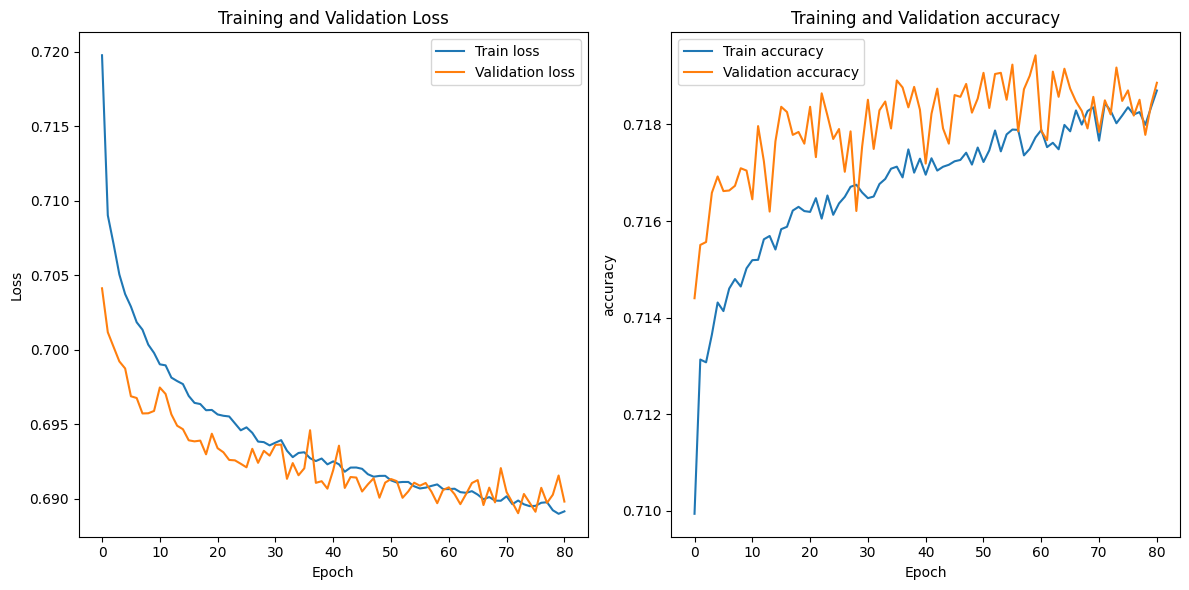

In [32]:
# Se realizan los gráficos para ver la loss de validation / train y las métricas correspondientes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training y Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation accuracy
axes[1].plot(train_metric_by_epoch, label="Train accuracy")
axes[1].plot(valid_metric_by_epoch, label="Validation accuracy")
axes[1].legend()
axes[1].set_title("Training and Validation accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("accuracy")

plt.tight_layout()
plt.show()

**Gráfico de training | validation Loss**

 - **Train loss:** la pérdida en entrenamiento desciende constantemente a lo largo de las épocas, lo que indica que el modelo está aprendiendo de los datos de entrenamiento.
- **Validation loss:** la pérdida de validación también disminuye inicialmente y luego empieza a estabilizarse en un valor similar a la pérdida de entrenamiento, con algunas fluctuaciones. No hay un aumento significativo, por lo que el modelo corta antes de las épocas fijadas (200), debido al early stopping, lo que indica que el modelo está generalizando bien a los datos de validación. No se aprecia sobreajuste en este gráfico, por lo que estaría ajustando bien.

**Gráfico de training | validation *accuracy***
- **Train Accuracy:**  mejora de manera constante hasta cierto punto, donde parece estabilizarse. Esto puede indicar que el modelo está aprendiendo bien y mejorando su capacidad de predecir correctamente en los datos de entrenamiento.
- **Valid Accuracy:** inicialmente mejora más rápido que la métrica de entrenamiento y luego oscila alrededor de un valor similar a la métrica de entrenamiento (parece estar convergiendo). Las fluctuaciones en la métrica de validación relativamente pequeñas, el modelo no parece estar sobreajustando significativamente.

### Parte (c)

Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.

In [33]:
# Vemos cuantas categorías únicas tiene cada variable

# Usuarios
print(len(embeddings['User_ID'].unique()))

# Productos
print(len(embeddings['Product_ID'].unique()))

5891
3631


In [34]:
# Renombramos las variables para tenerlas bien claras después en el modelo
user_id = embeddings['User_ID']
product_id = embeddings['Product_ID']

In [35]:
# Hacemos un head para ver que estés cargadas ok
product_id.head()

,Product_ID
0,P00069042
1,P00248942
2,P00087842
3,P00085442
4,P00285442


In [36]:
# Transformamos user_id / product_id a indices (idx) consecutivos para utilizar embeddings

user_id_to_idx = {value:i for i,value in enumerate(embeddings['User_ID'].unique())}
product_id_to_idx = {value:i for i,value in enumerate(embeddings['Product_ID'].unique())}

# Vector de vendor_idx en el dataset
user_idx = np.array([user_id_to_idx[value] for value in user_id])
product_idx = np.array([product_id_to_idx[value] for value in product_id])

In [37]:
# Dividimos el vector user_idx / product_idx en entrenamiento y validación
# (según los indices utilizados antes, para que siga misma muestra)

user_idx_train = user_idx[train_idx]
user_idx_valid = user_idx[valid_idx]

product_idx_train = product_idx[train_idx]
product_idx_valid = product_idx[valid_idx]

In [38]:
# Clase Dataset de Pytorch con embeddings
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, user_idx, product_idx, y):
    self.x = x
    self.user_idx = user_idx
    self.product_idx = product_idx
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [39]:
# Se crean los dataset de entrenamiento / validación
train_ds_embeddings = MyDatasetWithEmbddings(x_train, user_idx_train, product_idx_train, y_train)
valid_ds_embeddings = MyDatasetWithEmbddings(x_valid, user_idx_valid, product_idx_valid, y_valid)

In [40]:
# Se utiliza DataLoader para entregar los dataset de a batches
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

En este caso se utiliza la arquitectura base anterior, pero se adapta para introducir la información de los embeddings. También se ajusta el nivel de dropout, dado que con los valores previos, el modelo sobreajustaba en el entrenamiento.

In [41]:
# Creamos la clase de la red
class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings1 = torch.nn.Embedding(num_embeddings=5891, embedding_dim=5)
        self.embeddings2 = torch.nn.Embedding(num_embeddings=3631, embedding_dim=5)
        self.linear_1 = torch.nn.Linear(in_features=81+5+5, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.4)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.4)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=4, bias=True)  # 4 clases

    def forward(self, x, user_idx, product_idx):
        embeddings_outputs1 = self.embeddings1(user_idx)
        embeddings_outputs2 = self.embeddings2(product_idx)
        x = torch.cat([x, embeddings_outputs1, embeddings_outputs2], dim=1)
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        return x

# Instanciamos la red y la copiamos al dispositivo
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.002)

# Epocas a utilizar como máx.
epochs = 200

# Creamos listas para ir guardando los valores de cada epoca y graficar luego
train_loss_by_epoch=[]
valid_loss_by_epoch=[]
train_metric_by_epoch=[]
valid_metric_by_epoch=[]

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
step = 0


################################## Entrenamiento ####################################

for epoch in range(epochs):
    nnnetWithEmbeddings.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader_emb):
        x_batch, embed_batch1, embed_batch2, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch1 = embed_batch1.to(device).int()
        embed_batch2 = embed_batch2.to(device).int()
        y_batch = y_batch.to(device).long()  # Etiquetas como enteros

        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)

    # Almaceno la loss de la epoch para graficar
    train_loss_by_epoch.append(epoch_loss)
    # Cálculo la métrica de la epoch
    train_metric = metrics.accuracy_score(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    ################################## Validación ##################################

    nnnetWithEmbeddings.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader_emb):
            x_batch, embed_batch1, embed_batch2, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch1 = embed_batch1.to(device).int()
            embed_batch2 = embed_batch2.to(device).int()
            y_batch = y_batch.to(device).long()

            # Paso forward
            nnet_output =  nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
            loss = loss_function(nnet_output, y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    valid_loss = valid_loss / len(valid_dataloader)
    # Almaceno la loss de la epoch para graficar
    valid_loss_by_epoch.append(valid_loss)
    valid_metric = metrics.accuracy_score(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid Metric: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss,4) < best_loss:
        best_loss = np.round(epoch_loss,4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break

Epoch 0 | Train/Valid loss: 0.7169 / 0.6511 | Train/Valid Metric: 0.7096 / 0.7286
Epoch 1 | Train/Valid loss: 0.6517 / 0.6203 | Train/Valid Metric: 0.7300 / 0.7396
Epoch 2 | Train/Valid loss: 0.6277 / 0.6072 | Train/Valid Metric: 0.7385 / 0.7461
Epoch 3 | Train/Valid loss: 0.6189 / 0.6022 | Train/Valid Metric: 0.7421 / 0.7498
Epoch 4 | Train/Valid loss: 0.6136 / 0.6021 | Train/Valid Metric: 0.7436 / 0.7494
Epoch 5 | Train/Valid loss: 0.6094 / 0.5997 | Train/Valid Metric: 0.7455 / 0.7512
Epoch 6 | Train/Valid loss: 0.6057 / 0.6008 | Train/Valid Metric: 0.7472 / 0.7495
Epoch 7 | Train/Valid loss: 0.6037 / 0.5962 | Train/Valid Metric: 0.7476 / 0.7521
Epoch 8 | Train/Valid loss: 0.6000 / 0.5950 | Train/Valid Metric: 0.7500 / 0.7526
Epoch 9 | Train/Valid loss: 0.5963 / 0.5933 | Train/Valid Metric: 0.7517 / 0.7540
Epoch 10 | Train/Valid loss: 0.5928 / 0.5919 | Train/Valid Metric: 0.7526 / 0.7539
Epoch 11 | Train/Valid loss: 0.5899 / 0.5911 | Train/Valid Metric: 0.7540 / 0.7555
Epoch 12 | Tra

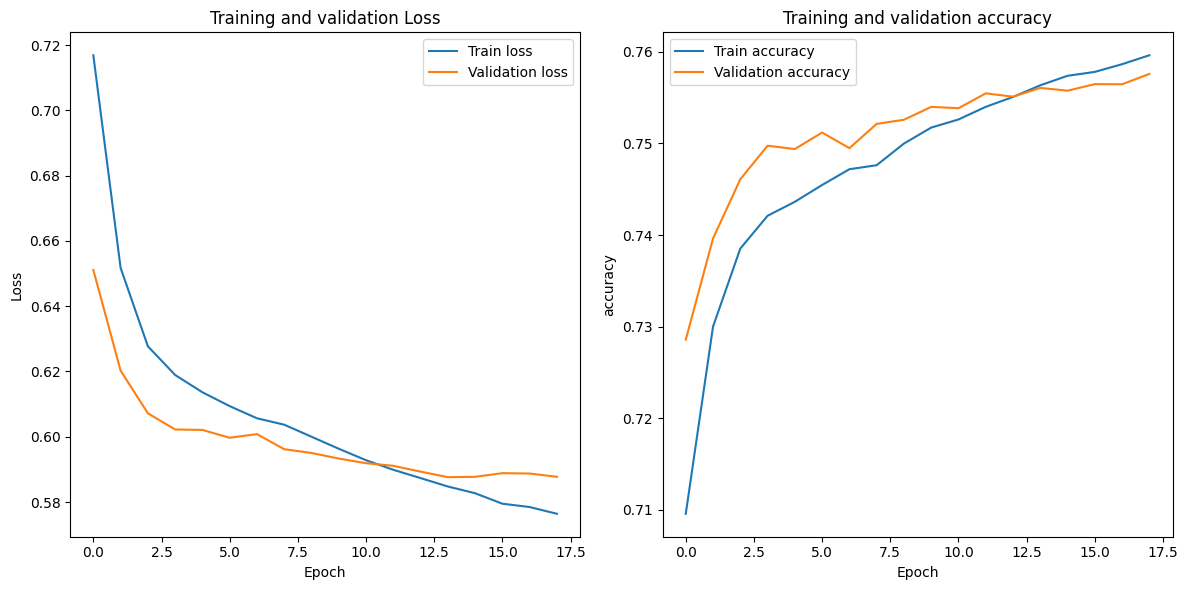

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training and Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation f1-score
axes[1].plot(train_metric_by_epoch, label="Train accuracy")
axes[1].plot(valid_metric_by_epoch, label="Validation accuracy")
axes[1].legend()
axes[1].set_title("Training and validation accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("accuracy")

plt.tight_layout()
plt.show()

**Gráfico de training | validation loss**

- **Train loss:** la pérdida de entrenamiento desciende de manera constante a lo largo de las épocas, lo que indica que el modelo está aprendiendo de los datos de entrenamiento y ajustándose bien a ellos.

- **Pérdida en validación:** en validación la pérdida disminuye inicialmente, pero luego se estabiliza (alrededor de la época 10-12) mostrando algunas fluctuaciones. Esto podría indicar que el modelo ha dejado de mejorar significativamente en cuanto a generalización después de ese punto, pero no muestra señales claras de sobreajuste, ya que la pérdida de validación no está aumentando de manera importante. La pérdida de validación es más baja que la pérdida de entrenamiento en varias épocas, lo que puede sugerir un caso donde los datos de validación son más fáciles de predecir o que hay un pequeño underfitting (subajuste). Sin embargo, dado que la diferencia no es grande y la pérdida de validación se estabiliza, parece estar funcionando de manera razonable.

**Gráfico de training | validation *accuracy***

- **Train accuracy:** el accuracy de entrenamiento mejora constantemente y alcanza un valor mayor a 0.75 al final del entrenamiento, lo cual sugiere que el modelo está aprendiendo correctamente a lo largo de las épocas.

- **Validation accuracy:** en validación la métrica sube rápidamente al principio y se estabiliza alrededor de la época 10-12. Esto es consistente con lo que observamos en el gráfico de la pérdida de validación. Las fluctuaciones son bastante pequeñas, lo que sugiere que la generalización del modelo es estable.

A partir de la época 10-12, tanto la métrica como la pérdida de validación parecen estabilizarse, por lo que corta por el *early stopping* para evitar entrenamientos innecesarios.

El modelo parece estar generalizando bien, ya que las métricas de entrenamiento y validación están bastante alineadas y no hay un aumento claro en la pérdida de validación. No hay señales claras de sobreajuste. En cuanto a la pérdida de validación, es más baja que la de entrenamiento en varios puntos, lo que puede indicar que el modelo aún no está aprovechando todo el poder predictivo. Podría estar ocurriendo un pequeño subajuste en las últimas épocas, aunque las diferencias son mínimas.



### Parte (d)

Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.

In [43]:
# Función para obtener usuarios similares
def find_similar_users(model, user_id, n=5):
    """
    Sugiere usuarios con un comportamiento de compras similar basado en embeddings.

    Inputs:
    - model: El modelo con embeddings entrenados.
    - user_id: ID del usuario objetivo.
    - n: Número de usuarios a sugerir (por defecto 5).

    Outputs:
    - Lista de IDs de los usuarios más similares.
    """

    # Se obtiene el embedding del usuario objetivo
    user_embedding = model.embeddings1(torch.tensor([user_id]).to(model.embeddings1.weight.device))

    # Se obtienen todos los embeddings de usuarios
    all_user_embeddings = model.embeddings1.weight

    # Se calcula la similitud coseno entre el usuario objetivo y todos los demás usuarios
    similarities = F.cosine_similarity(user_embedding, all_user_embeddings)

    # Orden por similitud y obtener los índices de los usuarios más cercanos
    similar_users = torch.argsort(similarities, descending=True)

    # Filtro el usuario objetivo para que no se devuelva a si mismo
    similar_users = similar_users[similar_users != user_id]

    # Se devuelve los n usuarios más similares
    return similar_users[:n].cpu().numpy()

# Ejemplo de uso:
similar_users = find_similar_users(nnnetWithEmbeddings, user_id=4566, n=10)
print("Usuarios similares:", similar_users)

Usuarios similares: [3755 4288 2031 2488 1512 2314 2142 3512  579 1635]


### Parte (e)

Entrenar un de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.

In [44]:
# Ahora el objetivo va a ser Purchase, por lo que se cambia el y
y = datos['Purchase']
y = y.to_numpy()
print(y.shape)

y_train = y[train_idx]
y_valid = y[valid_idx]

# Y escalamos FLAG!! VER SI FUNCIONA
y_train = (y_train - np.min(y_train, axis=0)) / (np.max(y_train, axis=0 ) - np.min(y_train, axis=0))
y_valid = (y_valid - np.min(y_valid, axis=0)) / (np.max(y_valid, axis=0 ) - np.min(y_valid, axis=0))

(550068,)


In [45]:
# Se crean los datasets de entrenamiento / validación
# y se utiliza DataLoader para entregar los dataset de a batches


train_ds_embeddings = MyDatasetWithEmbddings(x_train, user_idx_train, product_idx_train, y_train)
valid_ds_embeddings = MyDatasetWithEmbddings(x_valid, user_idx_valid, product_idx_valid, y_valid)

train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)


En este caso se utiliza la misma arquitectura que se venía manejando, pero se adapta a un problema de regresión:

- Se genera 1 único output como salida de la red (`out_features = 1`) en lugar de los 4 que se tenían antes (por las 4 clases que queríamos predecir).
- Se cambia la función de pérdida a `MSELoss` (pérdida por error cuadrático medio), dado que ahora tenemos una salida continua y se aplica una regresión.

In [46]:
# Se crea la clase del modelo y se ejecuta entrenamiento / validación

class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings1 = torch.nn.Embedding(num_embeddings=5891, embedding_dim=5)
        self.embeddings2 = torch.nn.Embedding(num_embeddings=3631, embedding_dim=5)
        self.linear_1 = torch.nn.Linear(in_features=81+5+5, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=1, bias=True)  # Regresión de un solo valor

    def forward(self, x, user_idx, product_idx):
        embeddings_outputs1 = self.embeddings1(user_idx)
        embeddings_outputs2 = self.embeddings2(product_idx)
        x = torch.cat([x, embeddings_outputs1, embeddings_outputs2], dim=1)
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)  # Salida continua
        return x


# Instanciamos la red y la copiamos al dispositivo
nnnetWithEmbeddings = NNetWithEmbeddings().to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.002)

epochs = 200
train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
patience_counter = 0

################################## Entrenamiento ####################################

for epoch in range(epochs):
    nnnetWithEmbeddings.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader_emb):
        x_batch, embed_batch1, embed_batch2, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch1 = embed_batch1.to(device).int()
        embed_batch2 = embed_batch2.to(device).int()
        y_batch = y_batch.to(device).float()  # Etiquetas como valores continuos

        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
        loss = loss_function(nnet_output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())  # Almacenar predicciones continuas

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch.append(epoch_loss)

    # Cálculo la métrica de regresión (MSE en este caso)
    train_metric = metrics.mean_absolute_error(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    ################################## Validación ##################################

    nnnetWithEmbeddings.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader_emb):
            x_batch, embed_batch1, embed_batch2, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch1 = embed_batch1.to(device).int()
            embed_batch2 = embed_batch2.to(device).int()
            y_batch = y_batch.to(device).float()  # Etiquetas deben ser continuas

            # Paso forward
            nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
            loss = loss_function(nnet_output.squeeze(), y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())  # Almacenar predicciones continuas

    valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch.append(valid_loss)

    # Cálculo la métrica de regresión (MSE)
    valid_metric = metrics.mean_absolute_error(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid MAE: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss, 4) < best_loss:
        best_loss = np.round(valid_loss, 4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break


Epoch 0 | Train/Valid loss: 0.0174 / 0.0134 | Train/Valid MAE: 0.0985 / 0.0849
Epoch 1 | Train/Valid loss: 0.0132 / 0.0114 | Train/Valid MAE: 0.0862 / 0.0796
Epoch 2 | Train/Valid loss: 0.0120 / 0.0111 | Train/Valid MAE: 0.0818 / 0.0780
Epoch 3 | Train/Valid loss: 0.0115 / 0.0108 | Train/Valid MAE: 0.0800 / 0.0768
Epoch 4 | Train/Valid loss: 0.0113 / 0.0109 | Train/Valid MAE: 0.0790 / 0.0772
Epoch 5 | Train/Valid loss: 0.0111 / 0.0108 | Train/Valid MAE: 0.0785 / 0.0772
Epoch 6 | Train/Valid loss: 0.0110 / 0.0107 | Train/Valid MAE: 0.0779 / 0.0764
Epoch 7 | Train/Valid loss: 0.0108 / 0.0106 | Train/Valid MAE: 0.0773 / 0.0762
Epoch 8 | Train/Valid loss: 0.0107 / 0.0105 | Train/Valid MAE: 0.0768 / 0.0755
Epoch 9 | Train/Valid loss: 0.0106 / 0.0106 | Train/Valid MAE: 0.0765 / 0.0759
Epoch 10 | Train/Valid loss: 0.0106 / 0.0105 | Train/Valid MAE: 0.0762 / 0.0757
Epoch 11 | Train/Valid loss: 0.0105 / 0.0103 | Train/Valid MAE: 0.0760 / 0.0744
Epoch 12 | Train/Valid loss: 0.0104 / 0.0107 | Tra

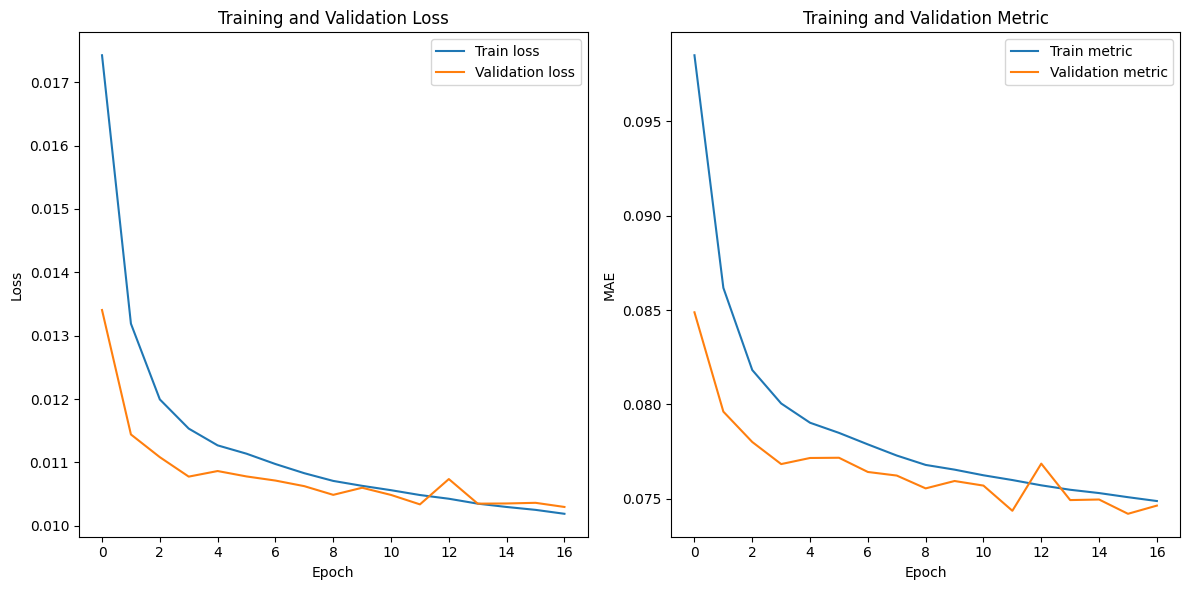

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training and Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation f1-score
axes[1].plot(train_metric_by_epoch, label="Train metric")
axes[1].plot(valid_metric_by_epoch, label="Validation metric")
axes[1].legend()
axes[1].set_title("Training and Validation Metric")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()


**Análisis de los resultados**

- En ambos gráficos, tanto la pérdida como la métrica (MAE) disminuyen de manera constante a lo largo de las épocas, lo que sugiere que el modelo está aprendiendo adecuadamente. A partir de la época 7-8, los valores comienzan a estabilizarse, lo que indica que el modelo podría estar cerca de alcanzar su capacidad óptima.

- La curva de pérdida y la curva de la métrica de validación siguen de cerca a las curvas de entrenamiento, lo que indica que no hay sobreajuste (overfitting). Si el modelo estuviera sobreajustando, la pérdida de validación comenzaría a aumentar mientras que la pérdida de entrenamiento continuaría disminuyendo, que no es precisamente lo que se ve.

- Las mejoras en el loss/métrica se desaceleran de forma temprana y por lo tanto corta la ejecución por el *early stopping*, por lo que parece que el modelo converge a un valor estable.

- Las curvas de validación están bastante alineadas con las de entrenamiento, lo que indica que el modelo tiene una buena capacidad para generalizar.



### Parte (f)

Para el mejor modelo obtenido en el apartado e) elegir al menos 2 hiperparámetros para tunear. Explicar el método utilizado y los resultados obtenidos.

En este caso se utilizará el framework de **[Optuna](https://optuna.readthedocs.io/en/stable/index.html)**, que aprovecha la búsqueda de hiperparámetros por optimización bayesiana. Esta técnica utiliza un balance entre exploración y explotación para realizar esta búsqueda, que consiste en:

- **Exploración:** probando nuevas combinaciones de hiperparámetros que no se han evaluado antes, lo que es útil para descubrir áreas en el espacio de búsqueda que podrían tener buenos resultados, pero aún no han sido exploradas.

- **Explotación:** centrandose en las áreas del espacio de búsqueda que ya han mostrado buenos resultados, probando combinaciones de hiperparámetros cercanas a las que han sido exitosas anteriormente.

In [48]:
import optuna
from optuna import Trial
from optuna.trial import TrialState

# Definimos la red neuronal con embeddings
class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.embeddings1 = torch.nn.Embedding(num_embeddings=5891, embedding_dim=5)
        self.embeddings2 = torch.nn.Embedding(num_embeddings=3631, embedding_dim=5)
        self.linear_1 = torch.nn.Linear(in_features=81+5+5, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(dropout_rate)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(dropout_rate)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=1, bias=True)  # Regresión de un solo valor

    def forward(self, x, user_idx, product_idx):
        embeddings_outputs1 = self.embeddings1(user_idx)
        embeddings_outputs2 = self.embeddings2(product_idx)
        x = torch.cat([x, embeddings_outputs1, embeddings_outputs2], dim=1)
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)  # Salida continua
        return x

# Función objetiva de Optuna para buscar los mejores hiperparámetros
def objective(trial: Trial):

    # Hiperparámetros a tunear
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # Tasa de aprendizaje
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Proporción de dropout

    # Instanciamos el modelo con los hiperparámetros propuestos por Optuna
    model = NNetWithEmbeddings(dropout_rate=dropout_rate).to(device)

    # Definimos la loss y el optimizador
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epochs = 20
    patience = 5
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Modo de entrenamiento
        model.train()
        epoch_loss = 0
        epoch_y, epoch_y_hat = [], []

        for i, data in enumerate(train_dataloader_emb):
            x_batch, embed_batch1, embed_batch2, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch1 = embed_batch1.to(device).int()
            embed_batch2 = embed_batch2.to(device).int()
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            nnet_output = model(x_batch, embed_batch1, embed_batch2)
            loss = loss_function(nnet_output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_y += list(y_batch.cpu().numpy())
            epoch_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())

        epoch_loss = epoch_loss / len(train_dataloader)

        # Validación
        model.eval()
        valid_loss = 0
        valid_y, valid_y_hat = [], []

        with torch.no_grad():
            for i, data in enumerate(valid_dataloader_emb):
                x_batch, embed_batch1, embed_batch2, y_batch = data
                x_batch = x_batch.to(device).float()
                embed_batch1 = embed_batch1.to(device).int()
                embed_batch2 = embed_batch2.to(device).int()
                y_batch = y_batch.to(device).float()

                nnet_output = model(x_batch, embed_batch1, embed_batch2)
                loss = loss_function(nnet_output.squeeze(), y_batch)
                valid_loss += loss.item()

                valid_y += list(y_batch.cpu().numpy())
                valid_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())

        valid_loss = valid_loss / len(valid_dataloader)

        # Early stopping
        if np.round(valid_loss, 4) < best_loss:
            best_loss = np.round(valid_loss, 4)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_loss

# Configuración de Optuna para el tuning de hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Resultados del estudio
print('Número de pruebas: ', len(study.trials))
print('Mejor prueba: ', study.best_trial.params)

[I 2024-10-20 15:45:43,838] A new study created in memory with name: no-name-30e1efe8-f5ba-4178-98d0-ff2ec0c140ae
[I 2024-10-20 15:51:52,651] Trial 0 finished with value: 0.0105 and parameters: {'lr': 0.0016504822224905878, 'dropout_rate': 0.33557774666407136}. Best is trial 0 with value: 0.0105.
[I 2024-10-20 15:59:32,833] Trial 1 finished with value: 0.0134 and parameters: {'lr': 3.379883482255123e-05, 'dropout_rate': 0.4739215235602242}. Best is trial 0 with value: 0.0105.
[I 2024-10-20 16:07:16,472] Trial 2 finished with value: 0.0115 and parameters: {'lr': 8.784165500513496e-05, 'dropout_rate': 0.10527202923090262}. Best is trial 0 with value: 0.0105.
[I 2024-10-20 16:15:01,623] Trial 3 finished with value: 0.0108 and parameters: {'lr': 0.0002667177839178957, 'dropout_rate': 0.26972944413501}. Best is trial 0 with value: 0.0105.
[I 2024-10-20 16:20:46,007] Trial 4 finished with value: 0.0104 and parameters: {'lr': 0.002859410961955197, 'dropout_rate': 0.20987808214048456}. Best is

Número de pruebas:  10
Mejor prueba:  {'lr': 0.002486742808583008, 'dropout_rate': 0.38110221519676135}


Debido a una limitación de tiempo y de uso de GPU en colab, se realizaron únicamente 10 pruebas (lo ideal sería realizar una cantidad mayor). De esta búsqueda de hiperparámetros se sugiere que el *learning rate* debería ser alrededor del doble (originalmente se utilizaba un $lr = 0.002$), así como el dropout que anteriormente se había especificado en $0.1$ (se apagaban el $10\%$ de las neuronas), se recomienda un aumento en este parámetro.

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros:
- numero de capas.
- numero de kernels.
- tamaño de kernels.


Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo en una gráfica con las curvas de los 5 modelos propuestos. Compare también el tiempo de entrenamiento y peso (tamaño) de cada modelo. Aplique técnicas de regularización para evitar overfitting. Elija el modelo que considera mejor y justifique.
Entregables:
 - Grafica comparativa de función de perdida vs epochs para los 5 modelos.
 - Grafica comparativa de función de accuracy vs epochs para los 5 modelos.
 - Tabla comparativa (o grafico de barras) del tiempo de entrenamiento y pesos de cada modelo.
 - Justificación del modelo elegio (qué consideró para elegir el modelo y bajo qué criterio).



In [49]:
import torch
from torch import nn, optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import time
import copy


In [50]:


# Cargamos los datos
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:03<00:00, 8001077.55it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171748.89it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 676618.89it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6226146.77it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



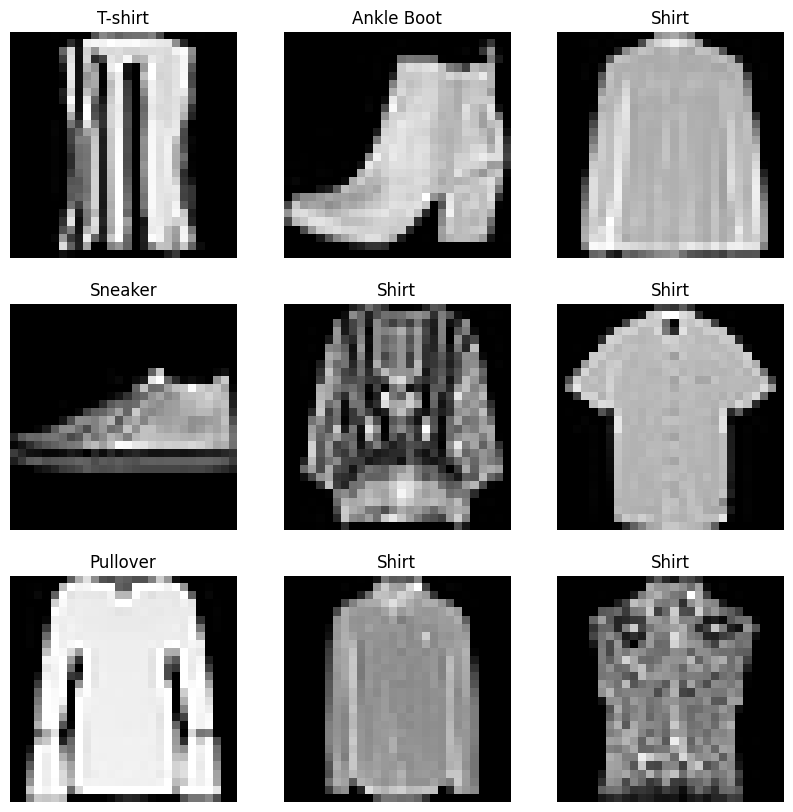

In [51]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [52]:
# Se utiliza DataLoader para entregar los dataset de a batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [53]:
# Se define la arquitectura del modelo base CNN
class CNNBase(nn.Module):
    def __init__(self):
        super(CNNBase, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Se definen las funciones de pérdida y el optimizador
model_base = CNNBase()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

In [54]:
# Se define el entrenamiento / validación
def train(model, train_loader, criterion, optimizer, test_loader=None, epochs=10):
    model.train()
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):
        running_loss = 0.0
        # Entrenamiento
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validación al final de cada época (si se proporciona test_loader)
        if test_loader is not None:
            epoch_val_loss, epoch_val_accuracy = evaluate(model, test_loader, criterion)
            val_loss.append(epoch_val_loss)
            val_accuracy.append(epoch_val_accuracy)

    if test_loader is not None:
        return train_loss, val_loss, val_accuracy
    else:
        return train_loss

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Iteración
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)  # Se predice la clase
            correct += pred.eq(labels.view_as(pred)).sum().item()  # Cuenta los aciertos

    # Calcular promedio de la pérdida y precisión para la época
    test_loss /= len(test_loader)  # Pérdida promedio
    accuracy = 100. * correct / len(test_loader.dataset)  # Precisión promedio

    return test_loss, accuracy

A continuación se realizan variantes del modelo base.

In [55]:
# Variante 1: Más capas
class CNNVariante1(nn.Module):
    def __init__(self):
        super(CNNVariante1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*3*3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128*3*3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Variante 2: Más kernels
class CNNVariante2(nn.Module):
    def __init__(self):
        super(CNNVariante2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Variante 3: Tamaño de kernel más grande
class CNNVariante3(nn.Module):
    def __init__(self):
        super(CNNVariante3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Variante 4: Dropout más fuerte
class CNNVariante4(nn.Module):
    def __init__(self):
        super(CNNVariante4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Aumentamos el dropout

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Variante 5: Menos kernels y capas
class CNNVariante5(nn.Module):
    def __init__(self):
        super(CNNVariante5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [56]:
# Se define el entrenamiento / validación
def train(model, train_loader, criterion, optimizer, test_loader=None, epochs=10):
    model.train()
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Entrenamiento
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calcular precisión en el conjunto de entrenamiento
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Guardar pérdida y precisión de entrenamiento por época
        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(100 * correct_train / total_train)

        # Validación al final de cada época (si se proporciona test_loader)
        if test_loader is not None:
            epoch_val_loss, epoch_val_accuracy = evaluate(model, test_loader, criterion)
            val_loss.append(epoch_val_loss)
            val_accuracy.append(epoch_val_accuracy)

    if test_loader is not None:
        return train_loss, train_accuracy, val_loss, val_accuracy
    else:
        return train_loss, train_accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0  # Inicializa como acumulador
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Itera sobre el conjunto de prueba
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()  # Acumula la pérdida correctamente
            pred = outputs.argmax(dim=1, keepdim=True)  # Predice la clase
            correct += pred.eq(labels.view_as(pred)).sum().item()  # Cuenta los aciertos

    # Calcular promedio de la pérdida y precisión para la época
    test_loss /= len(test_loader)  # Pérdida promedio
    accuracy = 100. * correct / len(test_loader.dataset)  # Precisión promedio

    return test_loss, accuracy  # Devuelve los valores correctos

# Se definen las funciones para entrenar y evaluar con tiempo y guardado de tamaño del modelo.
def train_and_evaluate_model(model_class, train_loader, test_loader, epochs=10):
    model = model_class()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()

    # Llamamos a train que ahora devuelve precisión de entrenamiento y validación
    train_losses, train_accuracies, val_losses, val_accuracies = train(
        model, train_loader, criterion, optimizer, test_loader=test_loader, epochs=epochs
    )

    test_loss, accuracy = evaluate(model, test_loader, criterion)

    end_time = time.time()
    training_time = end_time - start_time
    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return train_losses, val_losses, train_accuracies, val_accuracies, training_time, model_size

# Lista de los modelos variantes
model_variants = [CNNBase, CNNVariante1, CNNVariante2, CNNVariante3, CNNVariante4, CNNVariante5]

# Se crea una lista para guardar las métricas para cada modelo
results = {}

# Se entrena y evalua cada variante
for i, model_class in enumerate(model_variants):
    print(f"Entrenando el Modelo {i}")
    train_losses, val_losses, train_accuracies, val_accuracies, training_time, model_size = train_and_evaluate_model(
        model_class, train_loader, test_loader, epochs=10
    )
    results[f"Modelo {i}"] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        'training_time': training_time,
        'model_size': model_size
    }

# Mostramos los resultados
for model_name, metrics in results.items():
    print(f"\n Resultados para {model_name}:")
    print(f" - Pérdida de entrenamiento por época: {np.round(metrics['train_loss'],4)}")
    print(f" - Pérdida de validación por época: {np.round(metrics['val_loss'],4)}")
    print(f" - Precisión de entrenamiento por época: {np.round(metrics['train_accuracy'],4)}")
    print(f" - Precisión de validación por época: {np.round(metrics['val_accuracy'],4)}")
    print(f" - Tiempo de entrenamiento: {np.round(metrics['training_time'],4)} segundos")
    print(f" - Tamaño del modelo: {metrics['model_size']} parámetros")

Entrenando el Modelo 0
Entrenando el Modelo 1
Entrenando el Modelo 2
Entrenando el Modelo 3
Entrenando el Modelo 4
Entrenando el Modelo 5

 Resultados para Modelo 0:
 - Pérdida de entrenamiento por época: [0.501  0.287  0.2435 0.2129 0.1904 0.1684 0.1506 0.1316 0.1156 0.1011]
 - Pérdida de validación por época: [0.3585 0.2974 0.2648 0.2451 0.2458 0.2448 0.2374 0.2358 0.2551 0.2725]
 - Precisión de entrenamiento por época: [81.8383 89.47   90.9433 92.195  92.9133 93.7167 94.3967 95.1217 95.6983
 96.1867]
 - Precisión de validación por época: [86.76 89.25 89.86 90.92 90.85 91.39 91.59 92.11 91.58 91.63]
 - Tiempo de entrenamiento: 568.66 segundos
 - Tamaño del modelo: 421642 parámetros

 Resultados para Modelo 1:
 - Pérdida de entrenamiento por época: [0.5325 0.3063 0.2596 0.2276 0.2041 0.1829 0.1648 0.1463 0.1331 0.114 ]
 - Pérdida de validación por época: [0.3459 0.3007 0.2816 0.2586 0.258  0.2308 0.2424 0.2376 0.237  0.2548]
 - Precisión de entrenamiento por época: [80.5367 88.6417 90

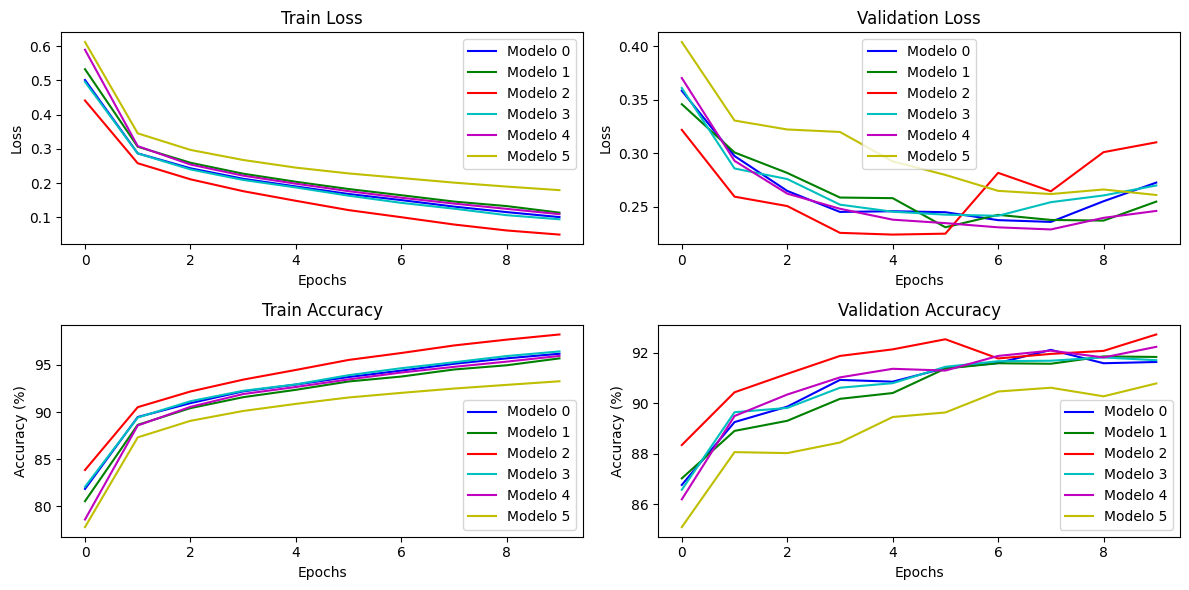

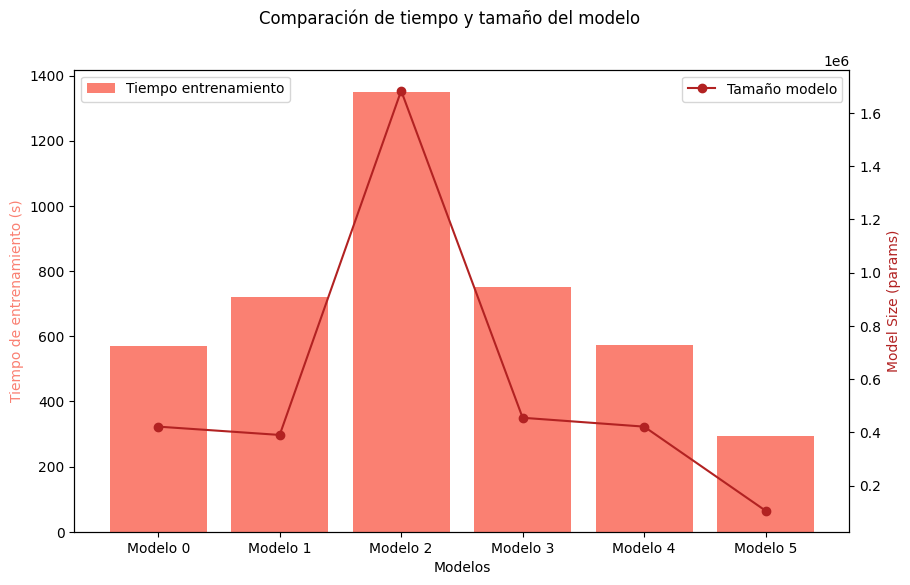

In [57]:
# Función para graficar las pérdidas y las precisiones
def plot_metrics(results):
    modelos = list(results.keys())
    epochs = len(results[modelos[0]]['train_loss'])

    # Crear una figura con subplots para train/val loss y train/val accuracy
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # Colores para los modelos
    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    # Train Loss
    for i, modelo in enumerate(modelos):
        axs[0, 0].plot(np.arange(epochs), results[modelo]['train_loss'], label=modelo, color=colors[i])
    axs[0, 0].set_title('Train Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Validation Loss
    for i, modelo in enumerate(modelos):
        axs[0, 1].plot(np.arange(epochs), results[modelo]['val_loss'], label=modelo, color=colors[i])
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Train Accuracy
    for i, modelo in enumerate(modelos):
        axs[1, 0].plot(np.arange(epochs), results[modelo]['train_accuracy'], label=modelo, color=colors[i])
    axs[1, 0].set_title('Train Accuracy')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Accuracy (%)')
    axs[1, 0].legend()

    # Validation Accuracy
    for i, modelo in enumerate(modelos):
        axs[1, 1].plot(np.arange(epochs), results[modelo]['val_accuracy'], label=modelo, color=colors[i])
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy (%)')
    axs[1, 1].legend()

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

# Función para graficar tiempos de entrenamiento y tamaño de modelo
def plot_time_and_size(results):
    modelos = list(results.keys())
    training_times = [results[modelo]['training_time'] for modelo in modelos]
    model_sizes = [results[modelo]['model_size'] for modelo in modelos]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Gráfico de barras para los tiempos de entrenamiento
    ax1.bar(modelos, training_times, color='salmon', label='Tiempo entrenamiento')
    ax1.set_xlabel('Modelos')
    ax1.set_ylabel('Tiempo de entrenamiento (s)', color='salmon')

    # Gráfico de líneas para el tamaño del modelo
    ax2 = ax1.twinx()  # Crear segundo eje y
    ax2.plot(modelos, model_sizes, color='firebrick', marker='o', label='Tamaño modelo')
    ax2.set_ylabel('Model Size (params)', color='firebrick')

    fig.suptitle('Comparación de tiempo y tamaño del modelo')

    # Leyendas
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Se ejecutan las funciones para graficar
plot_metrics(results)
plot_time_and_size(results)

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) **e identificar los números mayores o menores a 4,5**.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. Al reducir el train set, mantenga equilibrada la distribución de las clases.

Elija la estrategia de transfer learning acorde a los visto en la teoría y justifique su elección.

Compare las curvas de entrenamiento y accurracy empleando transfer learning o usando la arquitectura elejida en el punto anterior pero entrenando desde cero.
Entregables:
- Estrategia elegida y su justificación.
- Grafica comparativa de función de perdida vs epochs para el modelo con transfer learning y sin transfer learning.
- Grafica comparativa de función de accuracy vs epochs para el modelo con transfer learning y sin transfer learning.
- Comentarios sobre las curvas graficadas.


In [58]:
# Seleccionar device automáticamente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo CNN propuesto: Variante 3
class CNNVariante3(nn.Module):
    def __init__(self):
        super(CNNVariante3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 1)  # 1 output para clasificación binaria (>=4.5 or <4.5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Se carga MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Se crea conjunto de entrenamiento equilibrado
def create_balanced_subset(dataset, num_samples_per_class):
    class_indices = {i: np.where(np.array(dataset.targets) == i)[0] for i in range(10)}
    subset_indices = []
    for i in range(10):
        subset_indices += list(class_indices[i][:num_samples_per_class])
    return Subset(dataset, subset_indices)

train_subset = create_balanced_subset(train_dataset, 2000)  # 2000 por clase, total 20,000
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Se crea una función para pasar etiquetas a binarias (mayor o menor que 4.5)
def modify_labels_binary(dataset):
    dataset.targets = (dataset.targets >= 5).float()

modify_labels_binary(train_dataset)
modify_labels_binary(test_dataset)

# Función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10, use_transfer_learning=False):
    train_loss_history = []
    test_acc_history = []

    if use_transfer_learning:
        # Congela las capas convolucionales
        for param in model.conv1.parameters():
            param.requires_grad = False
        for param in model.conv2.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Se calcula accuracy en el conjunto de prueba
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                predicted = (outputs >= 0.5).float().squeeze()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc_history.append(100 * correct / total)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%')

    return train_loss_history, test_acc_history


# Se crea modelo, se define optimizador y pérdida
model_no_transfer = CNNVariante3().to(device)
model_with_transfer = CNNVariante3().to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy para clasificación binaria
optimizer_no_transfer = optim.Adam(model_no_transfer.parameters(), lr=0.001)
optimizer_with_transfer = optim.Adam(filter(lambda p: p.requires_grad, model_with_transfer.parameters()), lr=0.001)

# Entrenamiento sin transfer learning
print("Entrenando sin transfer learning...")
train_loss_no_tl, test_acc_no_tl = train_model(model_no_transfer, criterion, optimizer_no_transfer, train_loader, test_loader, use_transfer_learning=False)

# Entrenamiento con transfer learning
print("Entrenando con transfer learning...")
train_loss_tl, test_acc_tl = train_model(model_with_transfer, criterion, optimizer_with_transfer, train_loader, test_loader, use_transfer_learning=True)



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5104101.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 66575.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1276216.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4359388.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Entrenando sin transfer learning...
Epoch [1/10], Loss: 0.1972, Test Accuracy: 97.45%
Epoch [2/10], Loss: 0.0617, Test Accuracy: 98.17%
Epoch [3/10], Loss: 0.0443, Test Accuracy: 98.35%
Epoch [4/10], Loss: 0.0337, Test Accuracy: 98.61%
Epoch [5/10], Loss: 0.0259, Test Accuracy: 98.68%
Epoch [6/10], Loss: 0.0224, Test Accuracy: 98.83%
Epoch [7/10], Loss: 0.0181, Test Accuracy: 98.76%
Epoch [8/10], Loss: 0.0165, Test Accuracy: 98.89%
Epoch [9/10], Loss: 0.0153, Test Accuracy: 98.74%
Epoch [10/10], Loss: 0.0153, Test Accuracy: 98.95%
Entrenando con transfer learning...
Epoch [1/10], Loss: 0.3545, Test Accuracy: 93.79%
Epoch [2/10], Loss: 0.1851, Test Accuracy: 94.96%
Epoch [3/10], Loss: 0.1484, Test Accuracy: 94.75%
Epoch [4/10], Loss: 0.1313, Test Accuracy: 95.97%
Epoch [5/10], Loss: 0.1187, Test Accuracy: 96.16%
Epoch [6/10], Loss: 0.1093, Test Accuracy: 96.63%
Epoch [7/10], Loss: 0.1019, Test Accuracy: 96.21%
Ep

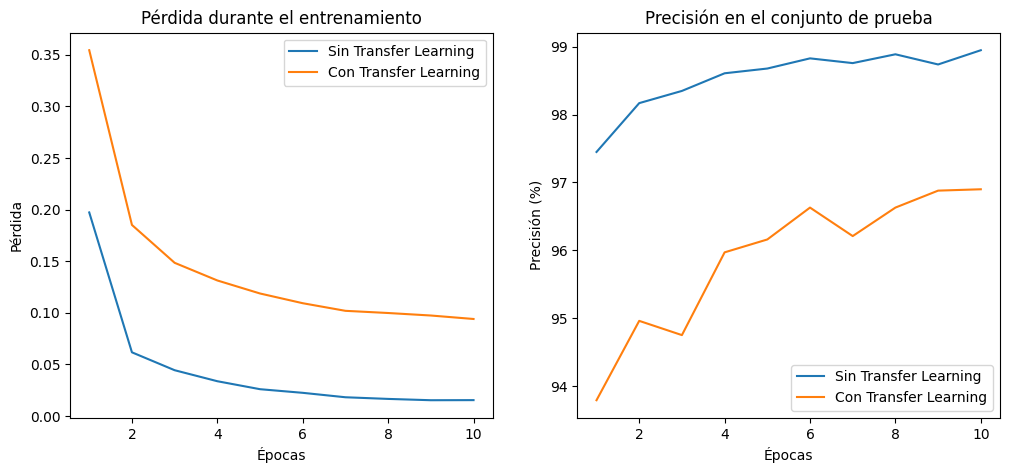

In [61]:
# Se grafican curvas de pérdida y accuracy
epochs = range(1, 11)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_no_tl, label='Sin Transfer Learning')
plt.plot(epochs, train_loss_tl, label='Con Transfer Learning')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_acc_no_tl, label='Sin Transfer Learning')
plt.plot(epochs, test_acc_tl, label='Con Transfer Learning')
plt.title('Precisión en el conjunto de prueba')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()

plt.show()